In [1]:
%load_ext autoreload
%autoreload 2

import torch

from rl4co.envs import CVRPEnv, CVRPTWEnv
from rl4co.models.nn.utils import rollout, random_policy
from rl4co.models.zoo.am import AttentionModel
from rl4co.utils.trainer import RL4COTrainer

In [2]:
env = CVRPTWEnv(
    num_loc=30,
    min_loc=0,
    max_loc=20,
    min_demand=1,
    max_demand=10,
    vehicle_capacity=1,
    min_time=0,
    max_time=480,
)

batch_size = 3

In [3]:
batch_size = 1
cvrp_env = CVRPEnv()
td = cvrp_env.reset(batch_size=[batch_size])

In [4]:
# randomly generated instance
batch_size = 1
td = env.reset(batch_size=[batch_size])
td

RuntimeError: batch dimension mismatch, got self.batch_size=torch.Size([1]) and value.shape[:self.batch_dims]=torch.Size([2]) with value tensor([9.7945, 3.9377])

In [6]:
# instance = CVRPTWEnv.load_data(fpath="../vrplib/data/instances/C101.txt")
import vrplib

instance = instance = vrplib.read_instance(path="../vrplib/data/instances/C101.txt", instance_format="solomon")
instance.keys()

dict_keys(['name', 'vehicles', 'capacity', 'node_coord', 'demand', 'time_window', 'service_time', 'edge_weight'])

In [15]:
td["locs"]

tensor([[[1.2769e+01, 9.2598e+00],
         [1.0189e+01, 1.6583e+01],
         [1.8316e+01, 1.9827e+01],
         [1.5845e+00, 1.6893e+01],
         [1.9274e+00, 1.3891e+01],
         [1.0641e+01, 1.8318e+01],
         [1.1675e+01, 7.9913e+00],
         [1.2566e+01, 3.5825e+00],
         [1.8158e+00, 8.7666e+00],
         [1.4504e+00, 6.6454e+00],
         [1.8119e+01, 4.2531e+00],
         [1.6388e+01, 9.2395e-01],
         [1.5398e+01, 1.4847e+01],
         [9.3843e+00, 1.3943e+01],
         [1.3680e+01, 8.4950e+00],
         [7.4396e+00, 6.8179e-01],
         [4.9564e+00, 1.4262e+01],
         [1.1353e+01, 1.9081e+01],
         [1.3048e+01, 1.6501e+01],
         [1.1395e+01, 2.5163e+00],
         [7.2480e+00, 7.0977e+00],
         [4.8584e+00, 1.3271e+01],
         [2.3987e+00, 5.2001e+00],
         [1.3277e+01, 9.9862e+00],
         [1.0375e+01, 5.4022e+00],
         [7.6852e+00, 3.8635e+00],
         [1.6292e+01, 7.1300e+00],
         [7.9052e+00, 7.7091e+00],
         [4.5552e+00

In [12]:
instance["node_coord"]

array([[40, 50],
       [45, 68],
       [45, 70],
       [42, 66],
       [42, 68],
       [42, 65],
       [40, 69],
       [40, 66],
       [38, 68],
       [38, 70],
       [35, 66],
       [35, 69],
       [25, 85],
       [22, 75],
       [22, 85],
       [20, 80],
       [20, 85],
       [18, 75],
       [15, 75],
       [15, 80],
       [30, 50],
       [30, 52],
       [28, 52],
       [28, 55],
       [25, 50],
       [25, 52],
       [25, 55],
       [23, 52],
       [23, 55],
       [20, 50],
       [20, 55],
       [10, 35],
       [10, 40],
       [ 8, 40],
       [ 8, 45],
       [ 5, 35],
       [ 5, 45],
       [ 2, 40],
       [ 0, 40],
       [ 0, 45],
       [35, 30],
       [35, 32],
       [33, 32],
       [33, 35],
       [32, 30],
       [30, 30],
       [30, 32],
       [30, 35],
       [28, 30],
       [28, 35],
       [26, 32],
       [25, 30],
       [25, 35],
       [44,  5],
       [42, 10],
       [42, 15],
       [40,  5],
       [40, 15],
       [38,  5

In [ ]:
# try random policy
batch_size = 3

print("Start rollout...")
reward, td, actions = rollout(
    env=env, td=env.reset(batch_size=[batch_size]), policy=random_policy, max_steps=100
)
print("Done.")
env.render(td, actions)

Start rollout...
Done.


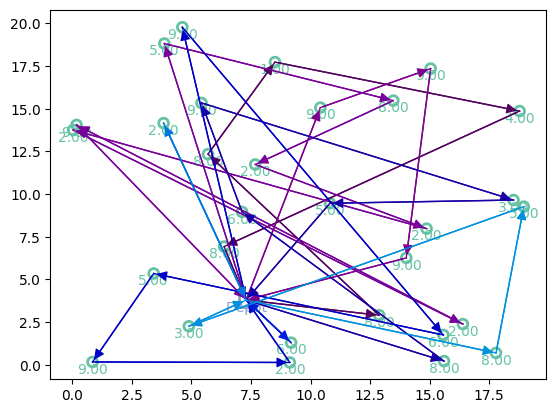

In [3]:
# try random policy
batch_size = 3

print("Start rollout...")
reward, td, actions = rollout(
    env=env, td=env.reset(batch_size=[batch_size]), policy=random_policy, max_steps=100
)
print("Done.")
env.render(td, actions)